In [1]:
def load_obj(name):
    with open(name+'.pkl', 'rb') as f:
        return pickle.load(f, encoding='latin1')

# Gaussian normalization, return 0 if std is 0
def normalize(obj, mean, std):
    a = obj-mean
    b=std
    return np.divide(a, b, out=np.zeros_like(a), where=b!=0)

In [736]:
##############
#IMPORTS
%reset
import pickle
import numpy as np
import copy 
from sklearn import decomposition
import os
import matplotlib.pyplot as plt
import yaml
from keras import models
from keras import layers
from keras import optimizers
import tensorflow as tf
from helpers import helper_functions



Once deleted, variables cannot be recovered. Proceed (y/[n])?  y


In [737]:
root_dir='/global/cscratch1/sd/al34/autoruns/lookback_with_0d_lookahead/ncomponents_None_lookback_3_prelayers_2_size_10_rnnsize_50_rnndropout_0_recurrentdropout_0_densedropout_0_'
input_dir='/global/homes/a/al34/data_files'
model_filename='model.h5'



# load conf file, 'config'
def load_config(config_file):
    with open(config_file) as f:
        config = yaml.load(f)
    return config

config=load_config(os.path.join(root_dir,'conf.yaml'))['data']


In [738]:
helper_functions.preprocess_data(dirname=config['input_dir_name'], 
                                    sigs_0d=config['sigs_0d'],
                                    sigs_1d=config['sigs_1d'],
                                    sigs_predict=config['sigs_predict'],
                                    n_components=config['n_components'],
                                    avg_window=config['avg_window'],
                                    lookback=config['lookback'],
                                    delay=config['delay'],
                                    train_frac=config['train_frac'],
                                    val_frac=config['val_frac'],
                                    save_data=True)

Removed 15 shots with empty arrays


KeyboardInterrupt: 

In [739]:

###############
#LOAD DATA




# load raw data, 'raw_data'
with open(os.path.join(input_dir,'final_data.pkl'), 'rb') as f: 
        raw_data=pickle.load(f, encoding='latin1')
        

# load processed train data, 'train_data'
with open(os.path.join(input_dir,'train_data.pkl'), 'rb') as f: 
        train_data=pickle.load(f, encoding='latin1')
        
        
# load processed val data, 'val_data'
with open(os.path.join(input_dir,'val_data.pkl'), 'rb') as f: 
        val_data=pickle.load(f, encoding='latin1')

# load processed train target, 'train_target'
with open(os.path.join(input_dir,'train_target.pkl'), 'rb') as f: 
        train_target=pickle.load(f, encoding='latin1')

# load processed val target, 'val_target'
with open(os.path.join(input_dir,'val_target.pkl'), 'rb') as f: 
        val_target=pickle.load(f, encoding='latin1')
        

# load processed shot indices, a dictionary, 'shot_dict'
with open(os.path.join(input_dir,'shot_indices.pkl'), 'rb') as f: 
        shot_dict=pickle.load(f, encoding='latin1')


# load model, 'loaded_model'
loaded_model=models.load_model(os.path.join(root_dir,model_filename))

loaded_model.compile(optimizer=optimizers.RMSprop(lr=.001),
                     metrics=['mae'], loss='mse')


# load process true train times, 'train_real_times'
with open(os.path.join(input_dir,'train_time.pkl'), 'rb') as f: 
        train_real_times=pickle.load(f, encoding='latin1')
        
# load process true val times, 'val_real_times'
with open(os.path.join(input_dir,'val_time.pkl'), 'rb') as f: 
        val_real_times=pickle.load(f, encoding='latin1')
        
        
# load standard rho points, 'rho_points'
with open(os.path.join(input_dir,'rho_standard.pkl'), 'rb') as f: 
        rho_points=pickle.load(f, encoding='latin1')


In [740]:
#################
#Data organization

#list of all the shots in sorted number, 'train_shot_nums'
train_shot_nums = shot_dict['train_shot_names']

#list of all the shots in sorted number, 'val_shot_nums'
val_shot_nums = shot_dict['val_shot_names']

# list of the indices where each shot begins in the data, 'train_shot_indices'
train_shot_indices = shot_dict['train_shot_indices']

# list of the indices where each shot begins in the data, 'val_shot_indices'
val_shot_indices = shot_dict['val_shot_indices']


# list of 0D and 1D signals, 'sig_keys_0d' and 'sig_keys_1d'
sig_keys_0d = config['sigs_0d'] #['curr_target', 'pinj']
sig_keys_1d = config['sigs_1d'] #['e_temp']

print(sig_keys_0d)
all_sigs = sig_keys_0d+sig_keys_1d




# delay and lookback values
delay = config['delay']
lookback = config['lookback']






['curr_target', 'pinj']


In [744]:
##################
#Data information
print("Number of total train shots: " + str(len(train_shot_nums)))
print("Number of val train shots: " + str(len(val_shot_nums)))


#Keys of a particular shot (signals)
print(raw_data[train_shot_nums[1]].keys())

#raw data keys (shot names)
sorted(raw_data.keys())[:5]

Number of total train shots: 624
Number of val train shots: 181
dict_keys(['pinj', 'curr_target', 'curr', 'gasA', 'gasB', 'e_temp', 'time', 'e_dens', 'tinj', 'i_dens'])


[160939, 160943, 160945, 160947, 160948]

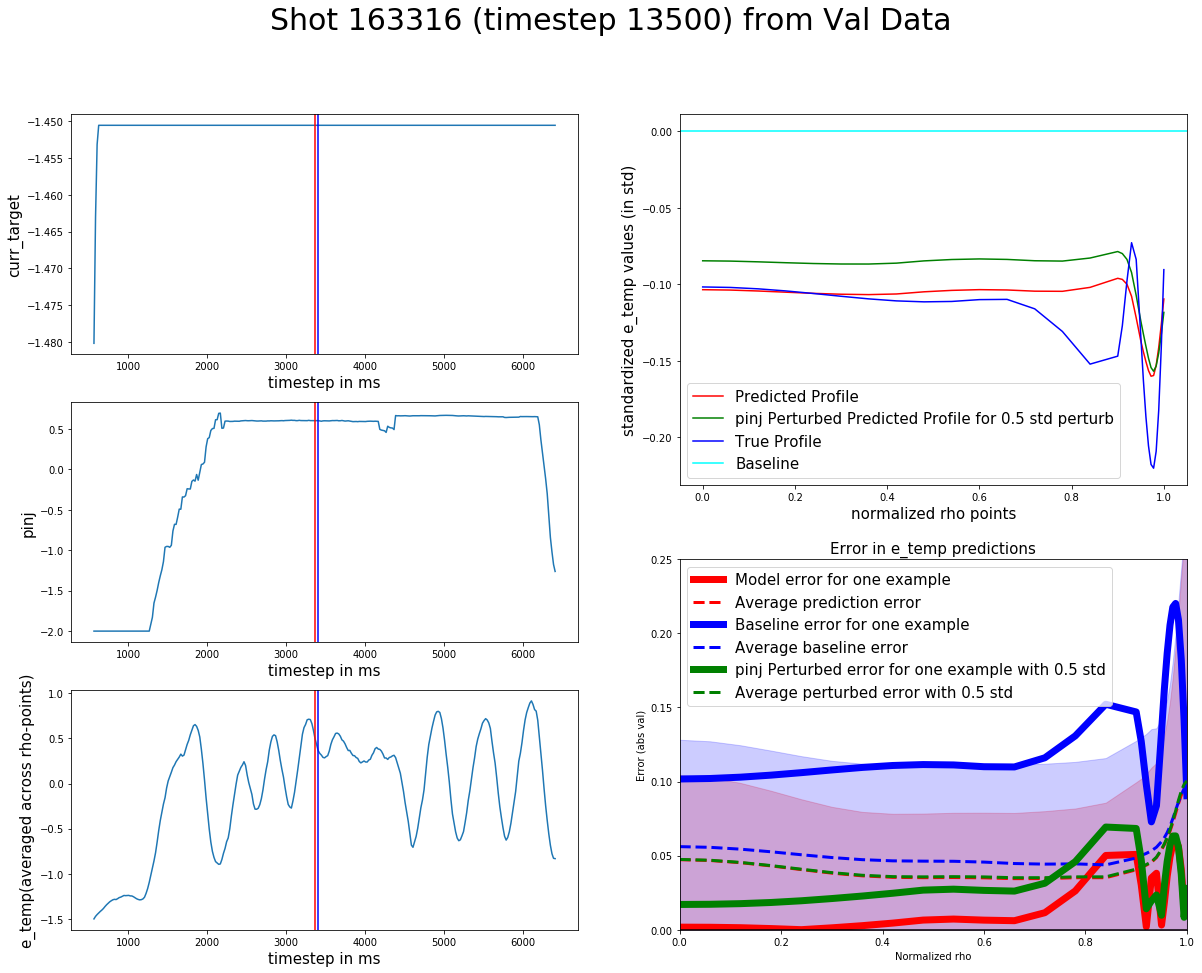

In [742]:


def plot_timestep(timestep, train, sig_to_perturb, perturb_amount):
    titlesize = 15
    
    if train:
        shot_indices = train_shot_indices
        data = train_data
        real_times = train_real_times
        shot_nums = train_shot_nums
        target = train_target
        
    else:
        shot_indices = val_shot_indices
        data = val_data
        real_times = val_real_times
        shot_nums = val_shot_nums
        target = val_target
    
    # shot index of timestep 
    shot_index = np.searchsorted(shot_indices, timestep, side='right')-1
    # range of times for that timestep's shot
    timestep_range = list(range(shot_indices[shot_index], shot_indices[shot_index+1]))
    fig = plt.figure(figsize = (20,15))
    
    # plot entire shot history for each 0D sig, with a vertical line symbolizing location 
    # of timestep of interest
    for i in range(len(sig_keys_0d)):
        plot_position = '{}2{}'.format(len(sig_keys_0d)+len(sig_keys_1d),2*i+1) 
        tmp_fig = fig.add_subplot(plot_position)
        # get the sig data from the processed data, (which has been shortened by smoothing/lookback)
        sig_data = np.ndarray.flatten(data[timestep_range, lookback, i])
        #joe's version below
        #sig_data=np.array(data)[timestep_range,-delay-1,i].T
        
        
        time_data = real_times[timestep_range]
        
        tmp_fig.plot(time_data, sig_data)
        tmp_fig.set_ylabel(sig_keys_0d[i], fontsize=titlesize)
        tmp_fig.set_xlabel("timestep in ms", fontsize=titlesize)
        tmp_fig.axvline(real_times[timestep],color='r')
        tmp_fig.axvline(real_times[timestep+delay],color='b')
        
        
    # plot entire shot history for each 1D sig (averaged rho's for each timestep), with a vertical line symbolizing location 
    # of timestep of interest    
    for i in range(len(sig_keys_1d)):
        plot_position = '{}2{}'.format(len(sig_keys_0d)+len(sig_keys_1d),2*(len(sig_keys_0d)+i)+1) 
        tmp_fig = fig.add_subplot(plot_position)
        rho_len_in = int((data.shape[2]-len(sig_keys_0d))/len(sig_keys_1d))
        sig_data = (data[timestep_range, lookback,len(sig_keys_0d)+i*rho_len_in:len(sig_keys_0d)+(i+1)*rho_len_in])
        # average the rho-values across each timestep
        sig_data = (np.mean(sig_data, axis = 1))
        time_data = real_times[timestep_range]
        tmp_fig.plot(time_data, sig_data)
        tmp_fig.axvline(real_times[timestep],color='r')
        tmp_fig.axvline(real_times[timestep+delay],color='b')
        tmp_fig.set_ylabel(sig_keys_1d[i] + "(averaged across rho-points)", fontsize=titlesize)
        tmp_fig.set_xlabel("timestep in ms", fontsize=titlesize)


    
    ##############################################################
    #plot the prediction profile, the true profile, and the baseline profile
    
    # input_data represents the training data slice for that particular timestep: shape (1, 6, 4)
    input_data=np.array(data)[timestep:timestep+1]
    
    predicted_profile = np.ndarray.flatten(loaded_model.predict(input_data))   
    
    true_profile = target[timestep]
    
    

    
    plot_position = 222
    tmp_fig = fig.add_subplot(plot_position)
    # plot predicted
    tmp_fig.plot(rho_points, predicted_profile, label = "Predicted Profile", color = 'r')
    
    
    
    #################################################################
    #perturb
    if sig_to_perturb is not None:
        if sig_to_perturb in sig_keys_0d:
            sig_index=sig_keys_0d.index(sig_to_perturb)
        else:
            # range of all 1D sigs
            sig_index=range(len(sig_keys_0d),input_data.shape[2])

       
        
        # input_data takes in the specific timestep of interest
        # perturbing the input by flatlining the 0d sig
        input_data_perturbed_no_change=input_data.copy()
        # keep the perturbed signal the same from the 0th index onwards
        input_data_perturbed_no_change[:,:,sig_index]=input_data_perturbed_no_change[:,0,sig_index]
        
        # 0 out the signal between current timestep and the delay timestep
        perturbed_zeroed_delay = input_data.copy()
        #perturbed_zeroed_delay[:, lookback+1:, sig_index] = 0
        # testing 5 times the sig_index
        perturbed_zeroed_delay[:, :, sig_index] = perturb_amount+perturbed_zeroed_delay[:, :, sig_index]
        
        
        # perturb the entire dataset for average perturbed error
        all_perturbed_data = data.copy()
        all_perturbed_data[:, :, sig_index] = perturb_amount+ all_perturbed_data[:, :, sig_index]
        
        
        
        
        
        # predict with the perturbations and plot
        perturbed_predicted_profile_no_change = np.ndarray.flatten(loaded_model.predict(input_data_perturbed_no_change))
        #tmp_fig.plot(rho_points, perturbed_predicted_profile_no_change, label = "Perturbed Predicted Profile (no change from first time)", color = "g")
        
        
        perturbed_predicted_profile_zeroed_delay = np.ndarray.flatten(loaded_model.predict(perturbed_zeroed_delay))
        tmp_fig.plot(rho_points, perturbed_predicted_profile_zeroed_delay, label = "{} Perturbed Predicted Profile for {} std perturb".format(sig_to_perturb, perturb_amount), color = "green")
        
        '''   
        
        # see how much the inputs/outputs changed 
        original_sig_window = input_data.copy()
        original_sig_window = np.ndarray.flatten(original_sig_window[:, :, sig_index])
        print(original_sig_window)
        time_window_range = real_times[timestep-lookback: timestep+delay+1]
        
        window_plot = fig.add_subplot(224)
        window_plot.plot(time_window_range, original_sig_window, label = "original {} window".format(sig_keys_0d[sig_index]), color = "red")
        window_plot.plot(time_window_range, np.ndarray.flatten(perturbed_zeroed_delay[:, :, sig_index]), label = "perturbed zeroed to delay for {} window".format(sig_keys_0d[sig_index]), color = "black")
        window_plot.plot(time_window_range, np.ndarray.flatten(input_data_perturbed_no_change[:, :, sig_index]), label = "perturbed no change for {} window".format(sig_keys_0d[sig_index]), color = "green")
        window_plot.set_ylabel(sig_keys_0d[sig_index], fontsize=titlesize)
        window_plot.set_xlabel("a 120ms timeframe representing the current-lookback to current+delay", fontsize=titlesize)
        window_plot.legend(loc="best")
    
        ''' 
    #########################################################################################
    
    # add baseline and true target
    # plot true
    tmp_fig.plot(rho_points, true_profile, label = "True Profile", color = 'b')
    # plot baseline (no change)
    tmp_fig.axhline(0,label='Baseline', color='cyan')
    tmp_fig.set_xlabel("normalized rho points", fontsize=titlesize)
    tmp_fig.set_ylabel("standardized e_temp values (in std)", fontsize=titlesize)
    


    tmp_fig.legend(loc = "best", fontsize=15)
    
    
    # print title out 
    if train:
        data_type = "Train"
    else:
        data_type = "Val"
    fig.suptitle('Shot {} (timestep {}) from {} Data'.format(shot_nums[shot_index],timestep, data_type), fontsize = 30)
       
    
    
    predicted_error = abs(true_profile - predicted_profile)
    baseline_error = abs(true_profile)
    perturbed_error = abs(true_profile - perturbed_predicted_profile_zeroed_delay)
    
    val_mae = abs(loaded_model.predict(data)-target)
    avg_val_mae=np.mean(val_mae, axis=0)
    std_val_mae=np.std(val_mae, axis=0)


    
    baseline_mae=abs(target)
    avg_baseline_mae=np.mean(baseline_mae, axis=0)
    std_baseline_mae=np.std(baseline_mae, axis=0)
    
    
    
    
    
    perturbed_mae = abs(loaded_model.predict(all_perturbed_data) - target)
    avg_perturbed_mae = np.mean(perturbed_mae, axis = 0)
    std_perturbed_mae = np.std(perturbed_mae, axis = 0)
    
    
    
    ax = fig.add_subplot('224')
    ax.set_title('Error in e_temp predictions', fontsize=titlesize)
    ax.plot(rho_points, predicted_error, color='red', label='Model error for one example', linewidth=7)
    ax.plot(rho_points, avg_val_mae, color='red', linestyle='--', label='Average prediction error', linewidth=3)
    ax.fill_between(rho_points,avg_val_mae-std_val_mae, avg_val_mae+std_val_mae, color='red', alpha=.2)
    ax.axhline(0,color='k')
    ax.plot(rho_points, baseline_error, color='b', label='Baseline error for one example', linewidth=7)
    ax.plot(rho_points, avg_baseline_mae, color='b', linestyle='--', label='Average baseline error', linewidth=3)
    ax.fill_between(rho_points,avg_baseline_mae-std_baseline_mae, avg_baseline_mae+std_baseline_mae, color='blue', alpha=.2)
    
    
    ax.plot(rho_points, perturbed_error, color='g', label='{} Perturbed error for one example with {} std'.format(sig_to_perturb, perturb_amount), linewidth=7)
    ax.plot(rho_points, avg_perturbed_mae, color='g', linestyle='--', label='Average perturbed error with {} std'.format(perturb_amount), linewidth=3)
    #ax.fill_between(rho_points,avg_perturbed_mae-std_perturbed_mae, avg_perturbed_mae+std_perturbed_mae, color='g', alpha=.2)

    ax.set_ylim(0,.25)
    ax.set_xlim(0,1)
    ax.legend(loc='upper left', fontsize=15)
    ax.set_ylabel('Error (abs val)', fontsize=10)
    ax.set_xlabel('Normalized rho', fontsize=10)
        
    
    

    
    

    
# timestep = np.random.choice(train_shot_indices)
timestep = np.random.choice(val_shot_indices) + 5
timestep = 13500
plot_timestep(timestep, False, 'pinj', +0.5)


2624


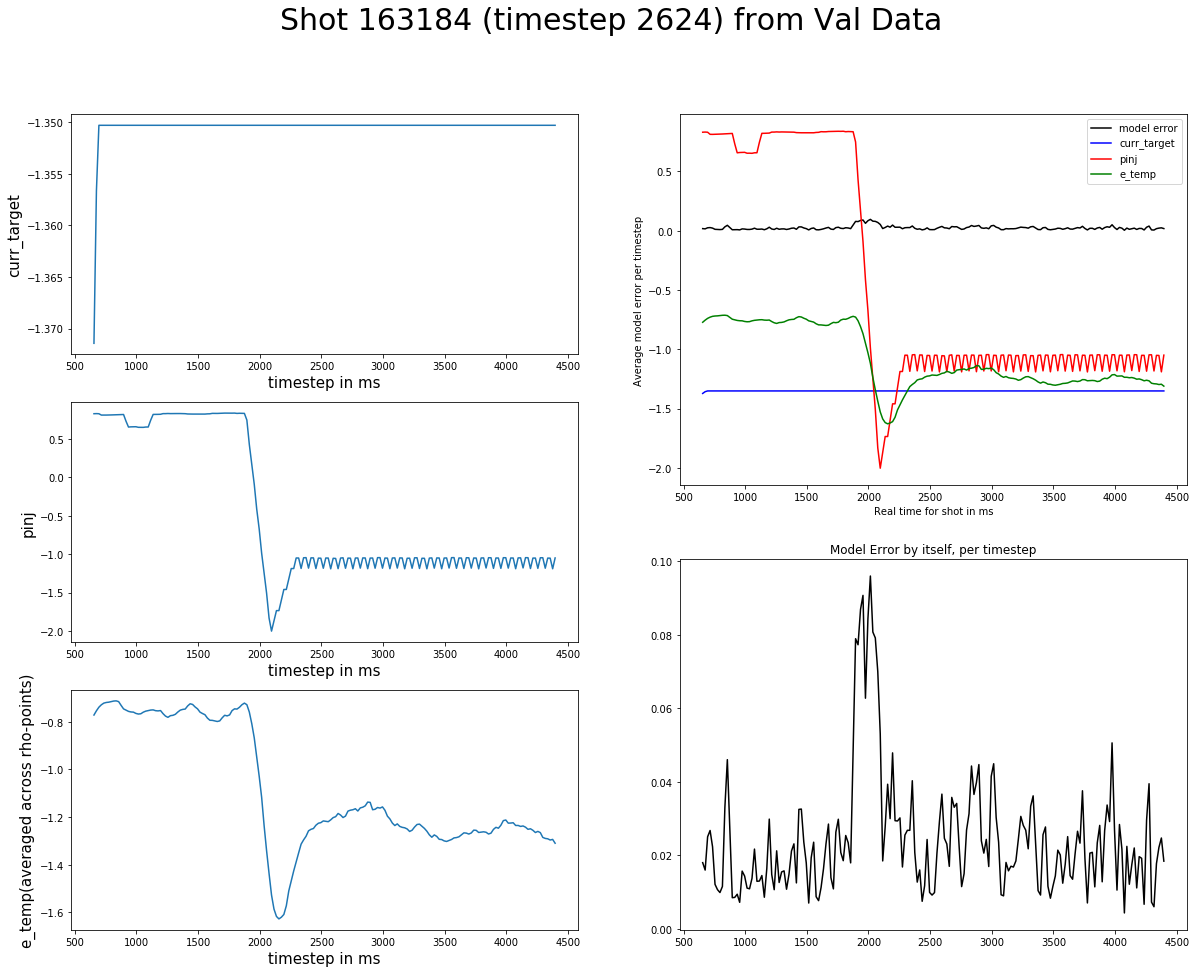

In [743]:
def error_per_shot(timestep, train):
    titlesize = 15
    
    if train:
        shot_indices = train_shot_indices
        data = train_data
        real_times = train_real_times
        shot_nums = train_shot_nums
        target = train_target
        
    else:
        shot_indices = val_shot_indices
        data = val_data
        real_times = val_real_times
        shot_nums = val_shot_nums
        target = val_target
    
    # shot index of timestep 
    shot_index = np.searchsorted(shot_indices, timestep, side='right')-1
    # range of times for that timestep's shot
    timestep_range = list(range(shot_indices[shot_index], shot_indices[shot_index+1]))
    fig = plt.figure(figsize = (20,15))
    
    for i in range(len(sig_keys_0d)):
        plot_position = '{}2{}'.format(len(sig_keys_0d)+len(sig_keys_1d),2*i+1) 
        tmp_fig = fig.add_subplot(plot_position)
        # get the sig data from the processed data, (which has been shortened by smoothing/lookback)
        sig_data = np.ndarray.flatten(data[timestep_range, lookback, i])
        #joe's version below
        #sig_data=np.array(data)[timestep_range,-delay-1,i].T
        
        
        time_data = real_times[timestep_range]
        
        tmp_fig.plot(time_data, sig_data)
        tmp_fig.set_ylabel(sig_keys_0d[i], fontsize=titlesize)
        tmp_fig.set_xlabel("timestep in ms", fontsize=titlesize)
        #tmp_fig.axvline(real_times[timestep],color='r')
        #tmp_fig.axvline(real_times[timestep+delay],color='b')
        
        
    # plot entire shot history for each 1D sig (averaged rho's for each timestep), with a vertical line symbolizing location 
    # of timestep of interest    
    for i in range(len(sig_keys_1d)):
        plot_position = '{}2{}'.format(len(sig_keys_0d)+len(sig_keys_1d),2*(len(sig_keys_0d)+i)+1) 
        tmp_fig = fig.add_subplot(plot_position)
        rho_len_in = int((data.shape[2]-len(sig_keys_0d))/len(sig_keys_1d))
        sig_data = (data[timestep_range, lookback,len(sig_keys_0d)+i*rho_len_in:len(sig_keys_0d)+(i+1)*rho_len_in])
        # average the rho-values across each timestep
        sig_data = (np.mean(sig_data, axis = 1))
        time_data = real_times[timestep_range]
        tmp_fig.plot(time_data, sig_data)
        #tmp_fig.axvline(real_times[timestep],color='r')
        #tmp_fig.axvline(real_times[timestep+delay],color='b')
        tmp_fig.set_ylabel(sig_keys_1d[i] + "(averaged across rho-points)", fontsize=titlesize)
        tmp_fig.set_xlabel("timestep in ms", fontsize=titlesize)
    

    error_over_shot = []
    # find errors per timestep
    for ts in timestep_range:
        predicted = np.ndarray.flatten(loaded_model.predict(data[ts:ts+1]))
        error = abs(predicted - target[ts])
        avg_error = np.mean(error)
        error_over_shot.append(avg_error)
        
    time_data = real_times[timestep_range]
    plot_position = 222
    tmp_fig = fig.add_subplot(plot_position)
    
    tmp_fig.plot(time_data, error_over_shot, color = 'black', label = "model error")
    
    
    for i in range(len(sig_keys_0d)):
       
        # get the sig data from the processed data, (which has been shortened by smoothing/lookback)
        sig_data = np.ndarray.flatten(data[timestep_range, lookback, i])
        #joe's version below
        #sig_data=np.array(data)[timestep_range,-delay-1,i].T
        
        
        time_data = real_times[timestep_range]
        
        if i==0:
            color = "blue"
        else:
            color = "red"
        tmp_fig.plot(time_data, sig_data, color = color, label = sig_keys_0d[i])
       
        
        
    # plot entire shot history for each 1D sig (averaged rho's for each timestep), with a vertical line symbolizing location 
    # of timestep of interest    
    for i in range(len(sig_keys_1d)):
        
        rho_len_in = int((data.shape[2]-len(sig_keys_0d))/len(sig_keys_1d))
        sig_data = (data[timestep_range, lookback,len(sig_keys_0d)+i*rho_len_in:len(sig_keys_0d)+(i+1)*rho_len_in])
        # average the rho-values across each timestep
        sig_data = (np.mean(sig_data, axis = 1))
        time_data = real_times[timestep_range]
        tmp_fig.plot(time_data, sig_data, label = sig_keys_1d[i], color = "green")

    
    
    
    tmp_fig.set_xlabel("Real time for shot in ms")
    tmp_fig.set_ylabel("Average model error per timestep")
    tmp_fig.legend(loc = "best")
    
    
    
    tmp_fig = fig.add_subplot(224)
    
    tmp_fig.plot(time_data, error_over_shot, color = 'black', label = "model error")
    tmp_fig.set_title("Model Error by itself, per timestep")
    
    if train:
        data_type = "Train"
    else:
        data_type = "Val"
    fig.suptitle('Shot {} (timestep {}) from {} Data'.format(shot_nums[shot_index],timestep, data_type), fontsize = 30)
    
    
    

        
    
    
    
    
    
timestep = timestep = np.random.choice(val_shot_indices) + 5
timestep = 2624
print(timestep)
error_per_shot(timestep, False)


#2624
#23404
#1466


timestep: 25604


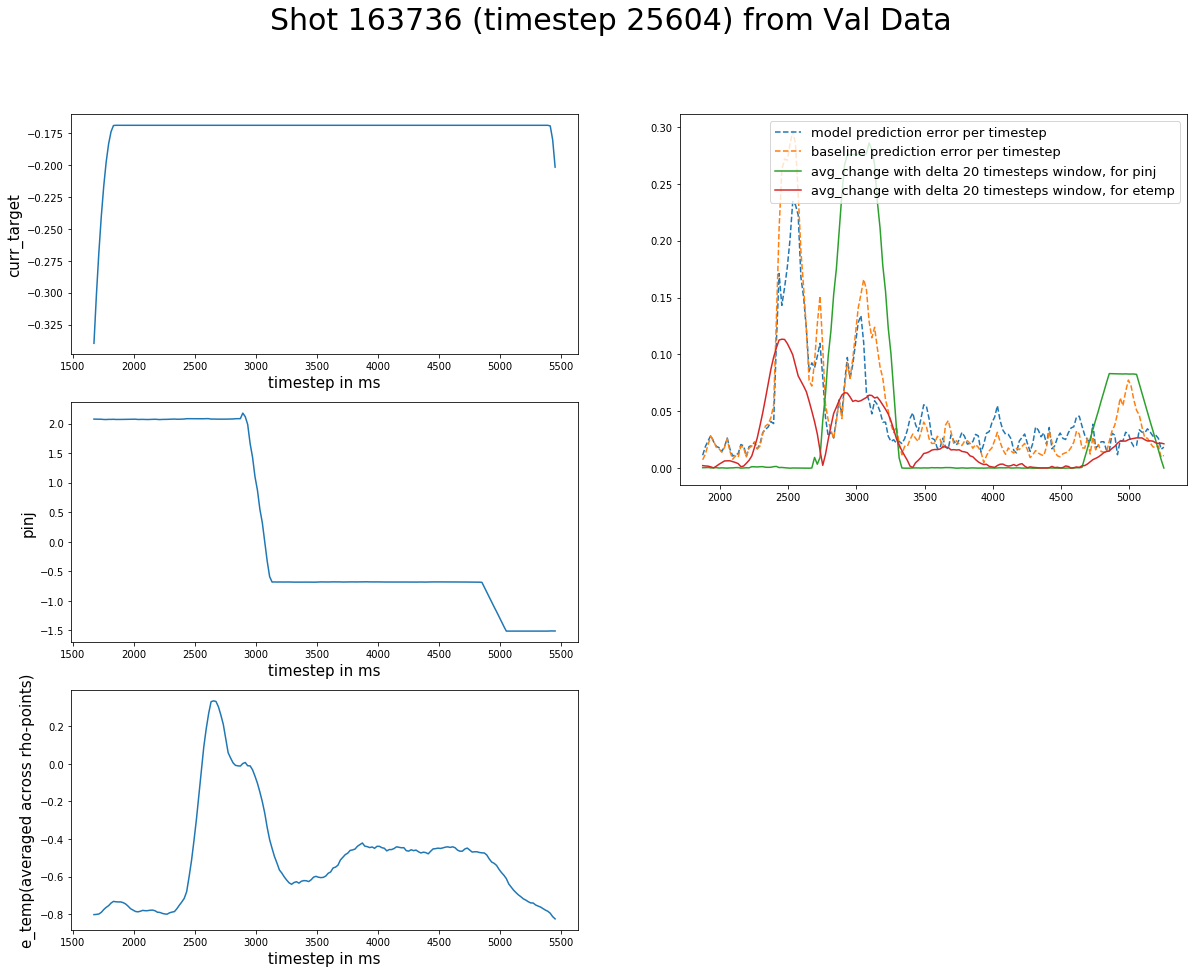

In [706]:
def plot_changes(timestep, train, sig_of_interest):
    titlesize = 15
    
    if train:
        shot_indices = train_shot_indices
        data = train_data
        real_times = train_real_times
        shot_nums = train_shot_nums
        target = train_target
        
    else:
        shot_indices = val_shot_indices
        data = val_data
        real_times = val_real_times
        shot_nums = val_shot_nums
        target = val_target
    
    # shot index of timestep 
    shot_index = np.searchsorted(shot_indices, timestep, side='right')-1
    # range of times for that timestep's shot
    timestep_range = list(range(shot_indices[shot_index], shot_indices[shot_index+1]))
    fig = plt.figure(figsize = (20,15))
    
    for i in range(len(sig_keys_0d)):
        plot_position = '{}2{}'.format(len(sig_keys_0d)+len(sig_keys_1d),2*i+1) 
        tmp_fig = fig.add_subplot(plot_position)
        # get the sig data from the processed data, (which has been shortened by smoothing/lookback)
        sig_data = np.ndarray.flatten(data[timestep_range, lookback, i])
        
        #joe's version below
        #sig_data=np.array(data)[timestep_range,-delay-1,i].T
        
        
        time_data = real_times[timestep_range]
        
        tmp_fig.plot(time_data, sig_data)
        tmp_fig.set_ylabel(sig_keys_0d[i], fontsize=titlesize)
        tmp_fig.set_xlabel("timestep in ms", fontsize=titlesize)
        #tmp_fig.axvline(real_times[timestep],color='r')
        #tmp_fig.axvline(real_times[timestep+delay],color='b')
        
        
    # plot entire shot history for each 1D sig (averaged rho's for each timestep), with a vertical line symbolizing location 
    # of timestep of interest    
    for i in range(len(sig_keys_1d)):
        plot_position = '{}2{}'.format(len(sig_keys_0d)+len(sig_keys_1d),2*(len(sig_keys_0d)+i)+1) 
        tmp_fig = fig.add_subplot(plot_position)
        rho_len_in = int((data.shape[2]-len(sig_keys_0d))/len(sig_keys_1d))
        sig_data = (data[timestep_range, lookback,len(sig_keys_0d)+i*rho_len_in:len(sig_keys_0d)+(i+1)*rho_len_in])
        # average the rho-values across each timestep
        sig_data = (np.mean(sig_data, axis = 1))
        time_data = real_times[timestep_range]
        tmp_fig.plot(time_data, sig_data)
        #tmp_fig.axvline(real_times[timestep],color='r')
        #tmp_fig.axvline(real_times[timestep+delay],color='b')
        tmp_fig.set_ylabel(sig_keys_1d[i] + "(averaged across rho-points)", fontsize=titlesize)
        tmp_fig.set_xlabel("timestep in ms", fontsize=titlesize)
    
    
    #####################################################################################
    # changes work
    
    
    # window of time calculating the avg change
    delta_time = 10
    
    # subset original data for pinj
    sig_index_pinj = sig_keys_0d.index('pinj')
    pinj_data = data.copy()
    pinj_data = np.ndarray.flatten(pinj_data[timestep_range, lookback, sig_index_pinj])

    
       
    
    avg_change_pinj = []
    
    
    # add the avg changes per timestep to the array 
    
    for ts in range(delta_time, len(pinj_data)-delta_time):
        avg_change_pinj.append(abs(pinj_data[ts+delta_time]-pinj_data[ts-delta_time])/delta_time)
    
    
    
    
    
    #etemp work
    rho_len_in = int((data.shape[2]-len(sig_keys_0d))/len(sig_keys_1d))
    etemp_data = (data[timestep_range, lookback,len(sig_keys_0d):len(sig_keys_0d)+rho_len_in])
    
    
    # average the rho-values across each timestep
    etemp_data = (np.mean(etemp_data, axis = 1))
    
    avg_change_etemp = []
    
    # add the avg change per timestep to the array
    for ts in range(delta_time, len(etemp_data)-delta_time):
        avg_change_etemp.append(abs(etemp_data[ts+delta_time]-etemp_data[ts-delta_time])/delta_time)
    
    
    delta_real_times = real_times[timestep_range[delta_time]: timestep_range[-1]+1-delta_time]
    
    
    
    
    # find the prediction error per timestep
    model_error_over_shot = []
    baseline_error_over_shot = []
    # find errors per timestep
    for ts in range(timestep_range[delta_time], timestep_range[-1]+1-delta_time):
        predicted = np.ndarray.flatten(loaded_model.predict(data[ts:ts+1]))
        error = abs(predicted - target[ts])
        avg_error = np.mean(error)
        model_error_over_shot.append(avg_error)
        
        avg_baseline_pred_error = np.mean(abs(target[ts]))
        baseline_error_over_shot.append(avg_baseline_pred_error)
    
        
        
        
    
    
    
    
    
    
    
    error_plot = fig.add_subplot(222)
    #error_plot.plot(error_time_data, avg_change)
    error_plot.plot(delta_real_times, model_error_over_shot, linestyle='--', label = "model prediction error per timestep")
    error_plot.plot(delta_real_times, baseline_error_over_shot, linestyle='--', label = "baseline prediction error per timestep")
    error_plot.plot(delta_real_times, avg_change_pinj, label = "avg_change with delta {} timesteps window, for pinj".format(2*delta_time))
    error_plot.plot(delta_real_times, avg_change_etemp, label = "avg_change with delta {} timesteps window, for etemp".format(2*delta_time))

    error_plot.legend(loc = "best", fontsize = 13)
    
    
    
#     tmp = fig.add_subplot(224)
#     tmp.scatter(avg_change_pinj, baseline_error_over_shot)
#     tmp.set_xlabel("avg_change (abs) with delta {} timesteps window, for {}".format(2*delta_time, sig_of_interest))
#     tmp.set_ylabel("baseline_error_over_shot", fontsize = 15)
    
    
    
    
    
    
    
    
    if train:
        data_type = "Train"
    else:
        data_type = "Val"
    fig.suptitle('Shot {} (timestep {}) from {} Data'.format(shot_nums[shot_index],timestep, data_type), fontsize = 30)
    
    
    
    
    
    
    
    

        
    
    
    
    
    
timestep = timestep = np.random.choice(val_shot_indices) + 5
timestep = 25604
print("timestep: " + str(timestep))
plot_changes(timestep, False, 'pinj')


#12 to 15 timestep, should this have anything based on rampup?

In [672]:

#model vs baseline error
shot_indices = val_shot_indices
data = val_data
real_times = val_real_times
shot_nums = val_shot_nums
target = val_target


# # for each shot...
# for i in range(len(shot_indices)-1):
#     timestep_range = list(range(shot_indices[i], shot_indices[i+1]))


model_error_array = []
baseline_error_array = []

# loop through every single timestep
for ts in range(shot_indices[-1]):
    predicted = np.ndarray.flatten(loaded_model.predict(data[ts:ts+1]))
    error = abs(predicted - target[ts])
    avg_error = np.mean(error)
    model_error_array.append(avg_error)
    
    baseline_error_array.append(np.mean(abs(target[ts])))
    

    

Text(0.5, 1.0, 'each dot represents prediction for one timestep')

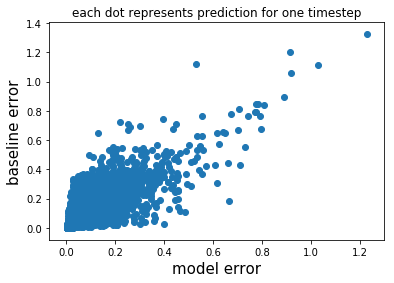

In [693]:
plt.scatter(model_error_array, baseline_error_array)
plt.xlabel("model error", fontsize = 15)
plt.ylabel("baseline error", fontsize = 15)
plt.title("each dot represents prediction for one timestep")


In [718]:

avg_change_pinj = []
avg_change_etemp = []
model_error_over_shot = []
baseline_error_over_shot = []

for timestep in shot_indices[:40]:
#for timestep in range(25604, 25605):
    shot_index = np.searchsorted(shot_indices, timestep, side='right')-1
    # range of times for that timestep's shot
    timestep_range = list(range(shot_indices[shot_index], shot_indices[shot_index+1]))
    
    # window of time calculating the avg change
    delta_time = 10
    
    # subset original data for pinj
    sig_index_pinj = sig_keys_0d.index('pinj')
    pinj_data = data.copy()
    pinj_data = np.ndarray.flatten(pinj_data[timestep_range, lookback, sig_index_pinj])

    
       
    
    
    
    
    # add the avg changes per timestep to the array 
    
    for ts in range(delta_time, len(pinj_data)-delta_time):
        avg_change_pinj.append((pinj_data[ts+delta_time]-pinj_data[ts-delta_time])/delta_time)
    
    
    
    
    
    #etemp work
    rho_len_in = int((data.shape[2]-len(sig_keys_0d))/len(sig_keys_1d))
    etemp_data = (data[timestep_range, lookback,len(sig_keys_0d):len(sig_keys_0d)+rho_len_in])
    
    
    # average the rho-values across each timestep
    etemp_data = (np.mean(etemp_data, axis = 1))
    
    
    
    # add the avg change per timestep to the array
    for ts in range(delta_time, len(etemp_data)-delta_time):
        avg_change_etemp.append((etemp_data[ts+delta_time]-etemp_data[ts-delta_time])/delta_time)
        
        
    # find the prediction error per timestep
    
    # find errors per timestep
    for ts in range(timestep_range[delta_time], timestep_range[-1]+1-delta_time):
        predicted = np.ndarray.flatten(loaded_model.predict(data[ts:ts+1]))
        error = (predicted - target[ts])
        avg_error = np.mean(error)
        model_error_over_shot.append(avg_error)
        
        avg_baseline_pred_error = np.mean((target[ts]))
        baseline_error_over_shot.append(avg_baseline_pred_error)
        

    

Text(0, 0.5, 'model error over all shots')

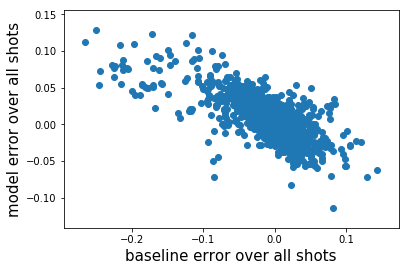

In [723]:
plt.scatter(baseline_error_over_shot, model_error_over_shot)
plt.xlabel("baseline error over all shots", fontsize = 15)
plt.ylabel("model error over all shots", fontsize = 15)

Text(0.5, 1.0, 'Concentrated points represent 90% of data, ~3000timesteps/3357')

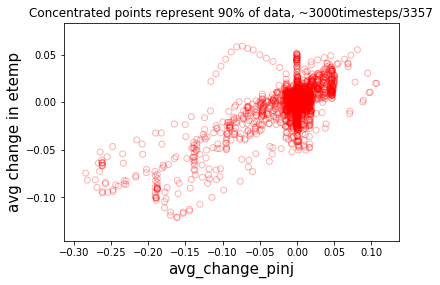

In [735]:
plt.scatter(avg_change_pinj, avg_change_etemp, facecolors='none', edgecolors='r', alpha = 0.3)
plt.xlabel("avg_change_pinj", fontsize = 15)
plt.ylabel("avg change in etemp", fontsize = 15)
plt.title("Concentrated points represent 90% of data, ~3000timesteps/3357")

In [732]:
sum = 0
print(len(avg_change_pinj))
for i in avg_change_pinj:
    if i>-0.04 and i < 0.05:
        sum= sum +1
print(sum)


3357
3046


In [795]:
def listMaker(keys):
    a = []
    for key in keys:
        a.append(key)
        
    return a


keys_list = []
for i in range(len(train_shot_nums)):
    a = listMaker(raw_data[train_shot_nums[i]].keys())
    keys_list.extend(a)
    
    
# np.unique()
print(len(train_shot_nums))

key_count = {}
for key in keys_list:
    if key in key_count:
        key_count[key]+=1
    else:
        key_count[key] = 1
(key_count)


624


{'elongation_up': 471,
 'curr': 624,
 'e_temp': 624,
 'pinj': 624,
 'triangularity_up': 471,
 'curr_target': 624,
 'drsep': 547,
 'elongation_low': 471,
 'Z0': 471,
 'tinj': 624,
 'R0': 471,
 'zeta_in_up': 471,
 'epsilon': 471,
 'zeta_out_up': 471,
 'press': 547,
 'triangularity_low': 471,
 'zeta_in_low': 471,
 'gasA': 624,
 'gasB': 624,
 'q': 547,
 'time': 624,
 'R_geo': 471,
 'zeta_out_low': 471,
 'e_dens': 620,
 'i_dens': 543,
 'i_temp': 530,
 'rotation': 529}

In [809]:
def explore_other_sigs(timestep, train, sig):    
    if train:
        shot_indices = train_shot_indices
        data = train_data
        real_times = train_real_times
        shot_nums = train_shot_nums
        target = train_target
        
    else:
        shot_indices = val_shot_indices
        data = val_data
        real_times = val_real_times
        shot_nums = val_shot_nums
        target = val_target
    
    shot_index = np.searchsorted(shot_indices, timestep, side='right')-1
    # range of times for that timestep's shot
    print(shot_indices[530])
    
    timestep_range = list(range(shot_indices[shot_index], shot_indices[shot_index+1]))
    
    # window of time calculating the avg change
    delta_time = 10
    
    # subset original data for pinj
    sig_index = sig_keys_0d.index(sig)
    sig_data = data.copy()
    sig_data = np.ndarray.flatten(sig_data[timestep_range, lookback, sig_index])

    plt.plot(sig_data)

explore_other_sigs(500, True, 'tinj')


107491


ValueError: 'tinj' is not in list